In [18]:
# Module Importations
import matplotlib.pylab as plt
import numpy as np
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
import tensorflow.keras as keras
import yellowbrick
from yellowbrick.regressor import PredictionError, ResidualsPlot

# Module Versioning
print('keras version: ', keras.__version__)
print('numpy version =', np.__version__)
print('sklearn: ' + sklearn.__version__)
print('tensorflow version: ', tf.__version__)
print('yellowbrick: ' + yellowbrick.__version__) 

keras version:  2.4.0
numpy version = 1.19.4
sklearn: 0.22.2.post1
tensorflow version:  2.4.1
yellowbrick: 1.2


In [2]:
# Custom Modules
from Source.Data import ntfp_dataset_import as data_load
from Source.Data import ntfp_split_data as split_data
from Source.Model import ntfp_keras_helpers as keras_helpers
from Source.Model import ntfp_model_evaluation as evaluation
from Source.Model import ntfp_tensorboard_helpers as tb_helpers
from Source.Visualisation import figs_helper

[keras_helpers]Tensorflow version: 2.4.1
[keras_helpers]keras version = 2.4.0


In [14]:
# Constants
SAVE_FIGS = False
TRAIN_MODELS = True

In [4]:
# Load Dataset (Use set from previous ML investigation)
filename = 'rul_dataset.pkl'
rul_df = data_load.load_pickled_data(filename)

print(rul_df)

Loading pickled dataframe started ...
Loading pickled dataframe complete ...
        Cycles   Sn_02    Sn_03    Sn_04   Sn_07    Sn_09  Sn_11   Sn_12  \
Engine                                                                     
1            1  641.82  1589.70  1400.60  554.36  9046.19  47.47  521.66   
1            2  642.15  1591.82  1403.14  553.75  9044.07  47.49  522.28   
1            3  642.35  1587.99  1404.20  554.26  9052.94  47.27  522.42   
1            4  642.35  1582.79  1401.87  554.45  9049.48  47.13  522.86   
1            5  642.37  1582.85  1406.22  554.00  9055.15  47.28  522.19   
...        ...     ...      ...      ...     ...      ...    ...     ...   
100        196  643.49  1597.98  1428.63  551.43  9065.52  48.07  519.49   
100        197  643.54  1604.50  1433.58  550.86  9065.11  48.04  519.68   
100        198  643.42  1602.46  1428.18  550.94  9065.90  48.09  520.01   
100        199  643.23  1605.26  1426.53  550.68  9073.72  48.39  519.67   
100        

In [5]:
# Split data into training and evaluation sets
training_set, evaluation_set = split_data.split_train_eval(rul_df, 0.2)

Original Data Items: 20631
Training Data Items: 16505
Evaluation Data Items: 4126


In [6]:
# Create RUL Target Dataset

# Training Set as Array
rul_training_data = training_set.drop('RUL', axis = 1).values
rul_training_label = training_set['RUL'].copy().values

print(rul_training_data.shape, rul_training_label.shape)

# Evaluation Set as Array
rul_eval_data = evaluation_set.drop('RUL', axis = 1).values
rul_eval_label = evaluation_set['RUL'].copy().values

print(rul_eval_data.shape, rul_eval_label.shape)

(16505, 13) (16505,)
(4126, 13) (4126,)


In [7]:
# Create train and test arrays
X_train, X_test, y_train, y_test = train_test_split(rul_training_data, rul_training_label, test_size = 0.2, random_state = 0)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(13204, 13) (3301, 13)
(13204,) (3301,)


In [8]:
# Initial MLP (Target - RUL)

if TRAIN_MODELS == True:
    # Clear existing models
    keras.backend.clear_session()

    # Build model
    model = keras_helpers.build_multilayer_perceptron()

    # Name model
    model_type = "MLP_RUL"
    model_id = keras_helpers.name_model(model_type)
    filepath_full = keras_helpers.make_save_string(model_id)

    # Set save and earlystop callbacks
    earlystop_cb = keras.callbacks.EarlyStopping(patience = 5)
    checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath = filepath_full, save_best_only = True)

    # Train model
    model.fit(X_train, y_train, epochs = 20, validation_data =(X_test, y_test), callbacks =[checkpoint_cb, earlystop_cb])

In [9]:
# Evaluate MLP Model

if TRAIN_MODELS == False:
    filepath_full = r'C:\Developer\nasa-turbofan-failure-prediction\Models\PM_MLP_RUL_2021_03_10-10_40_08.h5'

# Load model
model = keras.models.load_model(filepath_full)

# Summarise model
model.summary()

# Make predictions
rul_pred_eval = model.predict(rul_eval_data)

# Determine model prediction stats
model_name = "MLP_RUL"
evaluation.evaluate_model(model_name, rul_eval_label, rul_pred_eval)

# Calculate indicative accuracy
rmse, mae, r2 = evaluation.return_model_evaluation_stats(rul_eval_label, rul_pred_eval)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 84        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________
MLP_RUL rmse (Eval): 43.57223453547852
MLP_RUL mae (Eval): 32.86677266623404
MLP_RUL r2 (Eval): 0.5844209522226917


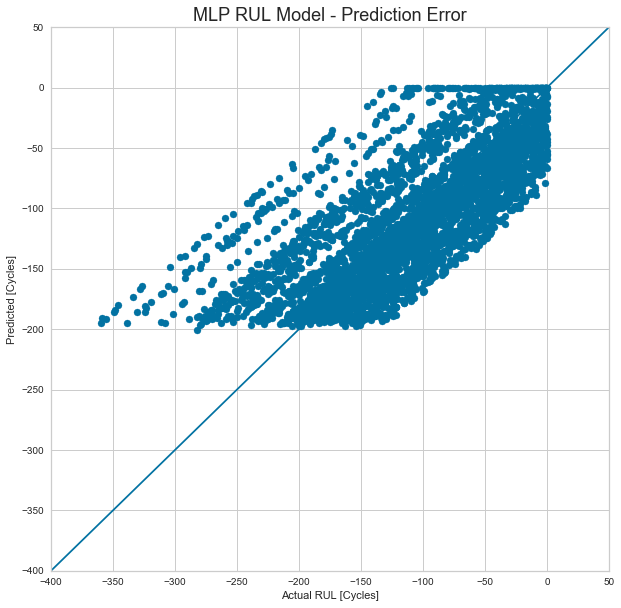

In [10]:
# Visualise Prediction Error (MLP - RUL)
if TRAIN_MODELS == False:
    filepath_full = r'C:\Developer\nasa-turbofan-failure-prediction\Models\PM_MLP_RUL_2021_03_10-10_40_08.h5'

# Load model
model = keras.models.load_model(filepath_full)
rul_prediction = model.predict(rul_eval_data).flatten()

# Plot predicted and actual data
plt.figure(figsize = (10, 10))
plt.scatter(rul_eval_label, rul_prediction)

# Set figure styling
plt.title('MLP RUL Model - Prediction Error', fontsize = figs_helper.TITLE_FONTSIZE)
plt.xlabel('Actual RUL [Cycles]')
plt.ylabel('Predicted [Cycles]')
lims = [-400, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save fig
if SAVE_FIGS == True: 
    name = 'MLP_RUL_Prediction_Err'
    save_string = figs_helper.generate_fig_save_string(name)
    plt.savefig(save_string, format = 'png', dpi = 600)

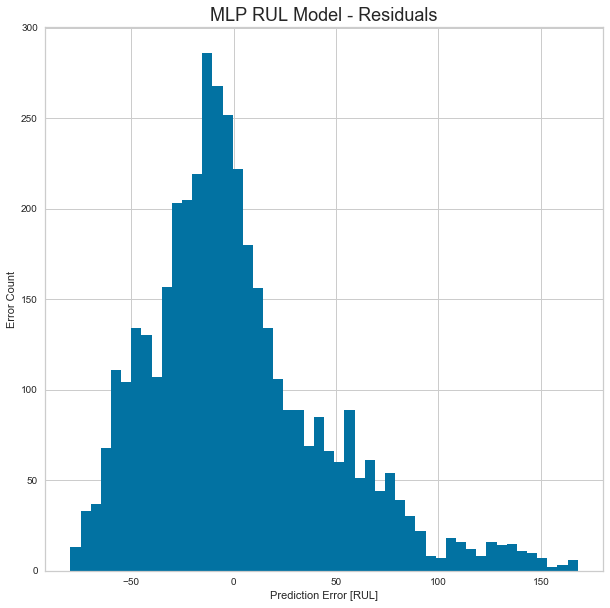

In [11]:
# Visualise Residual Error (MLP - RUL)
if TRAIN_MODELS == False:
    filepath_full = r'C:\Developer\nasa-turbofan-failure-prediction\Models\PM_MLP_RUL_2021_03_10-10_40_08.h5'

# Load model
model = keras.models.load_model(filepath_full)
error = rul_prediction - rul_eval_label

# Plot predicted and actual data
plt.figure(figsize = (10, 10))
plt.hist(error, bins = 50)

# Set figure styling
plt.title('MLP RUL Model - Residuals', fontsize = figs_helper.TITLE_FONTSIZE)
plt.xlabel('Prediction Error [RUL]')
plt.ylabel('Error Count')

# Save fig
if SAVE_FIGS == True: 
    name = 'MLP_RUL_Residuals'
    save_string = figs_helper.generate_fig_save_string(name)
    plt.savefig(save_string, format = 'png', dpi = 600)

In [12]:
# Setup Tensorboard for Logging
x = tb_helpers.get_run_logdir()

# Print tensorboard directory
print(x)

c:\Developer\nasa-turbofan-failure-prediction\Models\TensorBoard\run_2021_03_10-20_38_41


In [20]:
# Optimised MLP (Target - RUL)

if TRAIN_MODELS == True:
    # Clear existing models
    keras.backend.clear_session()

    # Establish parameter distribution for tuning
    param_distribs = {
        "n_hidden":[2, 4, 8, 16],
        "n_neurons": np.arange(1, 100),
        "learning_rate": [1e-1, 1e-2, 1e-3, 1e-4],
    }

    # Build model
    wrapped_model = keras_helpers.wrap_model()

    # Initialise random search
    rnd_search_cv = RandomizedSearchCV(wrapped_model, param_distribs, n_iter = 10, cv = 3)

    # Name model
    model_type = "MLP_Opt_RUL"
    model_id = keras_helpers.name_model(model_type)
    filepath_full = keras_helpers.make_save_string(model_id)

    # Set save and earlystop callbacks
    earlystop_cb = keras.callbacks.EarlyStopping(patience = 3)
    checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath = filepath_full, save_best_only = True)

    # Set TensorBoard callback for logging
    tb_logdir = tb_helpers.get_run_logdir()
    tensorboard_cb = keras.callbacks.TensorBoard(tb_logdir)

    # Train model
    rnd_search_cv.fit(X_train, y_train, epochs = 100, validation_data =(X_test, y_test), callbacks = [checkpoint_cb, earlystop_cb, tensorboard_cb])

Building Model ...
Hidden Layers: 16, Neurons: 90, LR: 0.1
Epoch 1/100
276/276 [==============================] - 3s 5ms/step - loss: nan - val_loss: nan
Epoch 2/100
276/276 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 3/100
138/138 [==============================] - 0s 1ms/step - loss: nan
Building Model ...
Hidden Layers: 16, Neurons: 90, LR: 0.1
Epoch 1/100
276/276 [==============================] - 2s 4ms/step - loss: nan - val_loss: nan
Epoch 2/100
276/276 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 3/100
138/138 [==============================] - 0s 1ms/step - loss: nan
Building Model ...
Hidden Layers: 16, Neurons: 90, LR: 0.1
Epoch 1/100
276/276 [==============================] - 3s 5ms/step - loss: nan - val_loss: nan
Epoch 2/100
276/276 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 3/100
138/138 [==============================] - 0s 1ms/step - loss: nan
Building Model .

RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001BBC7E37400>, as the constructor either does not set or modifies parameter n_neurons

In [21]:
# Evaluate MLP Model

if TRAIN_MODELS == False:
    filepath_full = r'C:\Developer\nasa-turbofan-failure-prediction\Models\PM_MLP_Opt_RUL_2021_03_10-20_41_33.h5'

# Load model
model = keras.models.load_model(filepath_full)

# Summarise model
model.summary()

# Make predictions
rul_pred_eval = model.predict(rul_eval_data)

# Determine model prediction stats
model_name = "MLP_RUL"
evaluation.evaluate_model(model_name, rul_eval_label, rul_pred_eval)

# Calculate indicative accuracy
rmse, mae, r2 = evaluation.return_model_evaluation_stats(rul_eval_label, rul_pred_eval)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_234 (Dense)            (None, 19)                266       
_________________________________________________________________
dense_235 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_236 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_237 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_238 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_239 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_240 (Dense)            (None, 19)              